# <center> Séries temporelles </center> #
<h1> <center> Christel Vrain </center> </h1>

<center>Université d'Orléans </center>

Ce TP a été réalisé pour des étudiants de M2 informatique et MIAGE de l'université d'Orléans. Il ne peut être diffusé, ni publié sans l'accord de son auteur.

C'est une initiation au traitement des séries temporelles. 

**Références:** 

    Python Data Science Handbook par Jake VanderPlas, edition O'Reilly https://jakevdp.github.io/PythonDataScienceHandbook/, Chapitre 3, Working with Time Series
    Les docs en ligne de Python et Pandas (https://pandas.pydata.org/docs/)
    
**Rappel :**
Vous pouvez avoir une aide en ligne sur toute fonction en la terminant par un ?


# PARTIE I : Introduction aux modèles ARIMA

Soit $X = [X_1, ... , X_t, ... , X_T]$ une série temporelle.

Pour tout $t$,  $X_t$ est une variable aléatoire à laquelle nous pouvons associer une espérance $\mu_t$, un écart-type $\sigma_t$ (Rappel : la variance est le carré de l'écart type).

Une série est stationnaire, si 
- $E(X_t) = \mu$ pour tout $t$ (les variables aléatoires ont toutes la même espérance)
- $E(|X_t|^2)$ est fini pour tout $t$, 
- $Cov(X_{r+u},X_{s+u}) = Cov(X_r,X_s)$, $\forall~ r,s,u$. On parle d'auto-covariance car on étudie la covariance de la série avec elle-même à des temps différents. 

Cela signifie que la relation entre $X_t$ et $X_{t+h}$ ne dépend que de $h$ (et non du temps $t$)

Nous ne connaissons pas l'espérance et l'auto-covariance. Nous les estimons par les formules suivantes

- estimation de l'espérance $\mu_t$ par la moyenne empirique 

$$\overline{X} = \frac{1}{T} \sum_{i=1}^T X_i$$

Remarque : si la série est supposée stationnaire, l'espérance est indépendante de $t$.

- estimation empririque de la variance par 

$$\hat{\sigma}(0) = \frac{1}{n} \sum_{i=1}^{T} (X_i - \overline{X})^2 $$



- estimation empirique de l'auto-covariance $cov(X_t, X_{t+h})$ par $\hat{\sigma}_h$ (si la série est supposée stationnaire, elle est indépendante de $t$).

$$\hat{\sigma}(h) = \frac{1}{n-h} \sum_{i=1}^{T-h} (X_i - \overline{X})(X_{i+h} - \overline{X}) $$

Ne pas faire de confusion : en général on note $\sigma$ l'écart type et $\sigma^2$ la variance. Ici on note $\hat{\sigma}(0)$ la variance empirique et $\hat{\sigma}(h)$ l'auto-covariance empirique d'ordre $h$.

Si la série est centrée, alors $\overline{X} = 0$ et les définitions de la variance et de l'auto-covariance sont simplifiées en conséquence.

L'auto-corrélation d'ordre $h$ est définie par :

$$\rho(h) = \frac{\hat{\sigma}(h)}{\hat{\sigma}(0)}$$

## Exercice ##

Un package utile pour l'analyse des séries temporelles est **statsmodels.tsa**
https://www.statsmodels.org/stable/tsa.html
   
On suppose que le prix mensuel moyen d'un litre de lait dans un supermarché a varié comme suit du 1er janvier au 1er décembre 2019

[0.92, 0.94, 0.93, 0.94, 0.95, 0.96, 0.92, 0.92, 0.93, 0.94, 0.95, 0.95]


Calculez l'auto-covariance et l'auto-corrélation d'ordre 3.


In [10]:
pow(10,2)



100

In [11]:
import numpy as np
lait=np.array([0.92, 0.94, 0.93, 0.94, 0.95, 0.96, 0.92, 0.92, 0.93, 0.94, 0.95, 0.95])

# En utilisant la formule ci-dessus, calculez l'auto-covariance d'ordre 3

def moyenne_empirique(lait):
    return np.sum(lait)/len(lait)

moyenne_empirique(lait)

def variance_empirique(lait):
    moyenne = moyenne_empirique(lait)
    return sum([ pow((i-moyenne),2) for i in lait])/len(lait)

def auto_covariance_empirique(lait,h):
    mu = moyenne_empirique(lait)
    cov=0
    for i in range(len(lait)-h):
        cov+=(lait[i]-mu)*(lait[i+h]-mu)
    return cov/(len(lait)-h)



In [12]:
# En utilisant la formule rappelée ci-dessus, calculez l'auto-corrélation d'ordre 3
def auto_cor(ts,h):
    return auto_covariance_empirique(ts,h)/auto_covariance_empirique(ts,0)

In [13]:
from statsmodels.tsa.stattools import acf
# Utiliser la fonction acf pour calculer l'auto-corrélation. Comparer les résultats.
acf?

Signature:
acf(
    x,
    adjusted=False,
    nlags=None,
    qstat=False,
    fft=True,
    alpha=None,
    bartlett_confint=True,
    missing='none',
)
Docstring:
Calculate the autocorrelation function.

Parameters
----------
x : array_like
   The time series data.
adjusted : bool, default False
   If True, then denominators for autocovariance are n-k, otherwise n.
nlags : int, optional
    Number of lags to return autocorrelation for. If not provided,
    uses min(10 * np.log10(nobs), nobs - 1). The returned value
    includes lag 0 (ie., 1) so size of the acf vector is (nlags + 1,).
qstat : bool, default False
    If True, returns the Ljung-Box q statistic for each autocorrelation
    coefficient.  See q_stat for more information.
fft : bool, default True
    If True, computes the ACF via FFT.
alpha : scalar, default None
    If a number is given, the confidence intervals for the given level are
    returned. For instance if alpha=.05, 95 % confidence intervals are
    returned wh

# Décomposition d'une série temporelle #

**Ce qui suit n'est qu'une introduction aux modèles ARIMA qui ne suffit pas pour utiliser correctement de tels modèles.**

Une série temporelle $X_t$ est souvent décomposée en plusieurs composantes: 

- la tendance, $f_t$, $1 \leq t \leq T$,  
- la composante saisonnière,  $s_t$, $1 \leq t \leq T$ 
- une variable aléatoire,  $e_t$, $1 \leq t \leq T$, souvent appelée *bruit* 
    
On peut étudier graphiquement la série et envisager un modèle additif ($x_t = f_t + s_t + e_t$), ou multiplicatif ($x_t = f_t.(1+s_t).(1+e_t)$) ou un modèle mixte.

## Données de vente de shampooings pendant 3 ans 
(Makridakis, Wheelwright and Hyndman (1998)) 

Le code qui suit est issu de https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

Données issues de https://datamarket.com/data/list/?q=provider:tsdl

<class 'pandas.core.series.Series'>
Longueur de la série : 36
Cinq premiers éléments : Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales of shampoo over a three year period, dtype: float64
Premier élément : 266.0
Index : DatetimeIndex(['1901-01-01', '1901-02-01', '1901-03-01', '1901-04-01',
               '1901-05-01', '1901-06-01', '1901-07-01', '1901-08-01',
               '1901-09-01', '1901-10-01', '1901-11-01', '1901-12-01',
               '1902-01-01', '1902-02-01', '1902-03-01', '1902-04-01',
               '1902-05-01', '1902-06-01', '1902-07-01', '1902-08-01',
               '1902-09-01', '1902-10-01', '1902-11-01', '1902-12-01',
               '1903-01-01', '1903-02-01', '1903-03-01', '1903-04-01',
               '1903-05-01', '1903-06-01', '1903-07-01', '1903-08-01',
               '1903-09-01', '1903-10-01', '1903-11-01', '1903-12-01'],
              dtype='datetime64[ns]', name='Month', freq=None)


/var/folders/0x/17syw9357z3cnf4g_699vjrh0000gn/T/ipykernel_48122/3489216299.py:15: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  shamp = read_csv('sales-of-shampoo-over-a-three-ye.csv', header=0,


<AxesSubplot: xlabel='Month'>

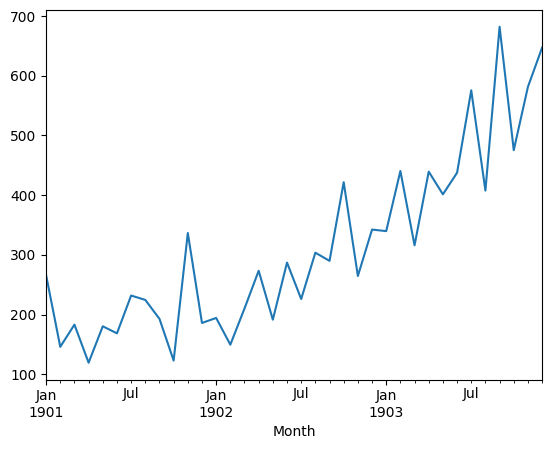

In [35]:
# Attention : on peut trouver
# from pandas import datetime
# mais pandas.datetime fait référence à la librairie classique de datatime dans Python
# Cela sera supprimé dans les versions futures

from pandas import read_csv
from datetime import datetime
from matplotlib import pyplot
%matplotlib inline

def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')


shamp = read_csv('sales-of-shampoo-over-a-three-ye.csv', header=0, 
                 parse_dates=[0], 
                 index_col=0, squeeze=True, 
                 date_parser=parser
                )
# index_col = 0 spécifie que la 1ère colonne sera utlisée comme un index (et donc notre série n'a qu'une colonne)
# squeeze :  False par défaut. Si True et si les données ont une seule colonne, alors retourne un objet Series
print(type(shamp))
print("Longueur de la série :", shamp.size)
print("Cinq premiers éléments :", shamp.head())
print("Premier élément :", shamp.iloc[0])
print("Index :", shamp.index)
shamp.plot()

# datetime est remplacé dans le futur par Timestamp 
#             https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Timestamp.html
# strptime n'est pas implanté dans Timestamp. Le remplacer par pd.to_datetime('190'+x, format='%Y-%m')



## 1- Détermination de la tendance

- **lissage par moyenne mobile** permet d'atténuer le bruit et avec des paramètres bien choisis de supprimer la composant saisonnière 

On remplace $X_t$ par $Y_t = \Sigma_{i=-k_1}^{i=k_2} \theta_i X_{t-i}$ pour $t$ in $\{k_1+1, ... , T-k_2\}$ (l'ordre du filtre est $k_1+k_2+1$)


Si $\Sigma \theta_i =1$, on parle de lissage\,; 

Si les $\theta_i$ sont égaux on parle de moyenne arithmétique, et si $k_1 = k_2$, on parle de moyenne arithmétique centrée. Si $k_1 = k_2 =p$ alors $Y_t = \frac{X_{t-p} + X_{t-p+1} + \ldots X_{t-1} + X_t  +
X_{t+1} + \ldots + X_{t+p}}{2 p +1}$

Si l'on connait la période $\tau$ des variations saisonnières, on prend $p$ tel que $\tau = 2p+1$.

- **estimation par régression** : 
        - Si on a un modèle additif et si la tendance semble linéaire, par la méthode des moindes carrés, on peut trouver une approximation de $X_t$ sous la forme  $a\times t + b$.
        - Si on a un modèle multiplicatif, on peut passer au log.

## 2- Suppression de la tendance.  

S'il y a une tendance, la série n'est pas stationnaire et donc on va chercher à supprimer la tendance pour étudier les autres composantes.

- **différences d'ordre 1** en remplaçant $X_t$  par  $\Delta t = X_t - X_{t-1}$ ou **d'ordre 2** en remplaçant $X_t$ par $\Delta' t = \Delta_t - \Delta_{t-1}$ et ainsi de suite. (Attention $\Delta_t - \Delta_{t-1} = X_t - 2X_{t-1} + X_{t-2}$). On a les propriétés suivantes :  
  - $\Delta(u_t+v_t) = \Delta(u_t) + \Delta(v_t)$ 
  - $\Delta(\lambda u_t) = \lambda \Delta(u_t)$  
  - Si $X_t= a_0+a_1*t + ... + a_k*t^k$, $\Delta^k(X_t)= k! a_k$ et $\Delta^{k+1}(X_t)= 0$.  En conséquence, si la tendance est polynomiale de degré k,  on peut supprimer la tendance en différenciant plusieurs fois 

## 3- Détermination de la composante saisonnière.

Une fois la tendance enlevée, la nouvelle série obtenue, $X_t = S_t + Z_t$ avec $S$ périodique de période $\tau$ et $Z_t$ une série temporelle stationnaire. La période, si elle existe,  correspond au maximum d'autocorrélation. 

$\rho_X(h) = \frac{Cov(X_t,X_{t+h})}{Cov(X_t,X_t)}$ avec $Cov(X_t,X_{t+h})=\frac{1}{N-h} \Sigma_{i=1}^{N-h}(X_i -\mu)(X_{i+h}-\mu)$

Il existe plusieurs manières d'estimer $S_k$ en fonction de l'allure de $S_t$. On peut par exemple faire la moyenne des observations disponibles à la date k pour chaque répétition de la période.

## 4- Modélisation de la composante aléatoire

processus à temps discret $\{e_1, ..., e_T\}$. Par exemple un bruit blanc, suite de variables indépendantes et identiquement distribuées, centrées (éventuellement réduites).
 
 

 



## Modèle ARIMA ##

A partir de ces considérations générales, on trouve  différentes modélisations d'un processus. Par exemple :
 
  - processus auto-régressif d'ordre p  (AR(p)): 
  $$X_t = \phi_1 X_{t-1} + ... + \phi_p X_{t-p} + \epsilon_t$$ 
  
  où les $\phi_k$ 
  
  
 - processus moyenne mobile: $X_t$ suit un modèle moyenne mobile d'ordre q (MA(q)) si
 
 $$X_t = \epsilon_t + \beta_1 \epsilon_{t-k-1} + \ldots \beta_q \epsilon_{t-q}$$
 
où les $\beta_k, k=1, ..., q$ sont les paramètres du modèles, les $\epsilon_t$ suivent une loi ${\cal N}(0, \sigma^2)$ et sont supposés indépendants et identiquement distribués. 
 


3 types de modèles dans ARIMA

- AR: Autoregression : $x_t  = f(x_{t-1}, ... , x_{t-k})$
    
- I: Integration $x_t-x_{t-1}$ pour rendre la série temporelle stationnaire. Cela permet d'enlever (partiellement) la tendance de la série.

- MA : Moyenne mobile (Moving Average)  dépendance entre $x_t$ et erreur résiduelle d'une moyenne mobile appliquée à des données précédentes

Paramètres d'un modèle ARIMA:

    p: décalage (* lag order*, nombre d'observations antérieures prises en compte)
    d: degré de différenciation (nombre de fois où les observations brutes sont différenciées) 
    q: ordre de la moyenne mobile (taille de la fenêtre mobile)
    
Possibilité de mettre la valeur 0 à un paramètre (modèle ARMA ou AR ou I ou MA)

La série n'est pas stationnaire. On a visiblement une tendance. if faut au moins différencier une fois 

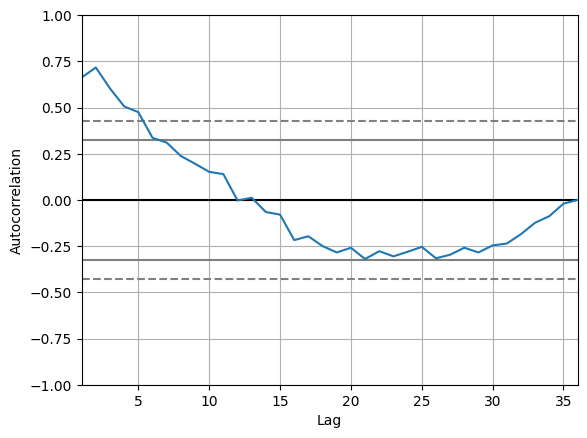

In [21]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(shamp)
pyplot.show()

Une corrélation positive sur les 12 premiers décalages (*lags*), important sur les 5 premiers. Attention l'autocorrelation à un décalage peut être la conséquence des auto-corrélations aux décalages précédents. On peut alors compléter l'analyse par un calcul d'autocorrélation partielle (par exemple l'autocorrelation partielle entre 1 et 4 mesure les corrélations qui ne sont pas prises en compte par les décalagees de 1 à 3.


In [26]:
from statsmodels.tsa.stattools import pacf
pacf(shamp,nlags=12)


array([ 1.        ,  0.68148799,  0.54944517,  0.13555047, -0.16690165,
       -0.00704597, -0.17481784, -0.04822996,  0.03387526,  0.04949134,
       -0.02470936,  0.10041495, -0.47473587])

/Users/jean-daniel/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jean-daniel/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jean-daniel/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<AxesSubplot: xlabel='Month'>

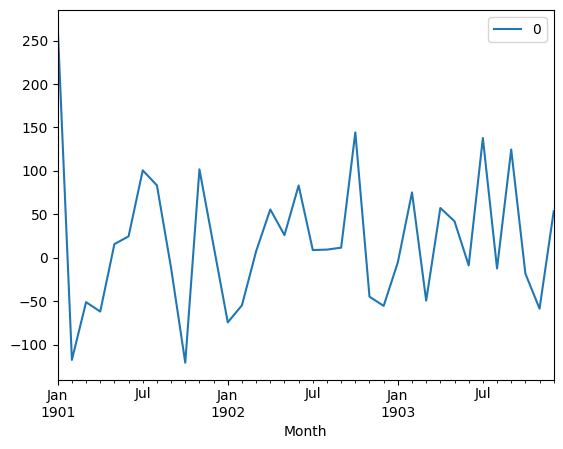

In [30]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot
model = ARIMA(shamp, order=(6,1,0), dates=shamp.index) 
# auto-regression de 5, différentiation de 1, moyenne mobile à 0
model_fit = model.fit() # modèle appris sur les données, 
#print(model_fit.summary())
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()



Il semble qu'il reste encore une tendance.

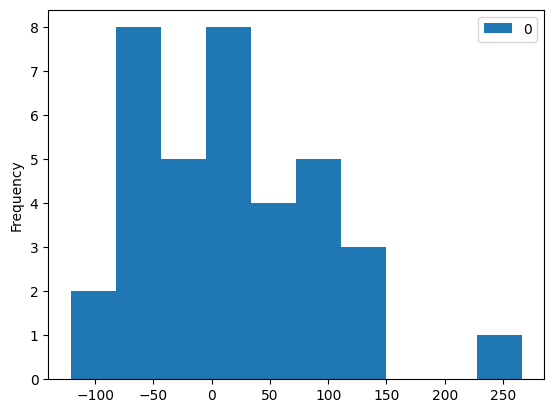

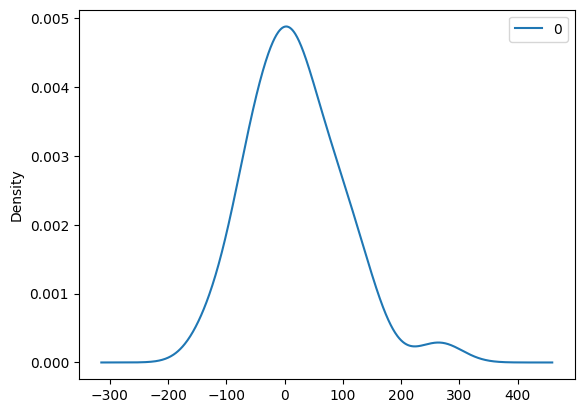

                0
count   36.000000
mean    19.333768
std     79.443494
min   -120.929368
25%    -46.036930
50%     10.457925
75%     61.730274
max    266.000000


In [33]:
pyplot.show()
residuals.plot(kind='hist')
residuals.plot(kind='kde') # estimation de la fonction de densité de la distribution des résiduels
# pour estimer la distribution en un point x on compte le nombre d'observations dans une fenêtre centrée autour de x
# pondérée par une gaussienne

pyplot.show()
print(residuals.describe())

Cela ressemble (mais pas totalement) à une gaussienne non centrée en 0 .

## Exercice : 

- Comment utiliser le modèle appris pour prédire une donnée ? (méthode forecast)

- Comment évaluer le modèle appris ?

## Exercice ##

On va utiliser la base de données  *monthly-milk-production-pounds-p.csv* que vous trouverez sous le lien *Production de lait* sous Celene

1- Donner la valeur en mars 1962  
2- Donner toutes les valeurs de 1963   
3- Afficher les points dans un graphique et étudier le comportement de la série  
4- Construire la série contenant le log de la série initiale (utiliser la fonction log de numpy) et l'afficher    
5- Suppression de la tendance  
    5.1 Faire une différenciation d'ordre 1 sur les données initiales en utilisant la méthode shift de pandas (regarder ce que donne l'appel à milk.shift() ) 
    5.2 Faire une différenciation d'ordre 1 sur les données logs   
    5.3 Faire une différenciation d'ordre 2 sur les données logs     
    5.4 Utiliser la fonction *detrend* de statsmodels.tsa.tsatools pour effacer la tendance    
6- Afficher une courbe donnant les coefficients d'autocorrélation  
7- Tester plusieurs modèles ARIMA  



In [36]:
import pandas as pd
def parser(x):
	return datetime.strptime(x, '%Y-%m')

milk = read_csv('monthly-milk-production-pounds-p.csv',header=0, index_col=0, squeeze=True,parse_dates=[0], date_parser=parser)
print(milk.index)

DatetimeIndex(['1962-01-01', '1962-02-01', '1962-03-01', '1962-04-01',
               '1962-05-01', '1962-06-01', '1962-07-01', '1962-08-01',
               '1962-09-01', '1962-10-01',
               ...
               '1975-03-01', '1975-04-01', '1975-05-01', '1975-06-01',
               '1975-07-01', '1975-08-01', '1975-09-01', '1975-10-01',
               '1975-11-01', '1975-12-01'],
              dtype='datetime64[ns]', name='Month', length=168, freq=None)


/var/folders/0x/17syw9357z3cnf4g_699vjrh0000gn/T/ipykernel_48122/2979039568.py:5: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  milk = read_csv('monthly-milk-production-pounds-p.csv',header=0, index_col=0, squeeze=True,parse_dates=[0], date_parser=parser)


In [38]:
milk['1962-03-01']

640

In [53]:
for i in [i for i in milk.index if i.year==1963]:
    print(i, milk[i])


1963-01-01 00:00:00 600
1963-02-01 00:00:00 566
1963-03-01 00:00:00 653
1963-04-01 00:00:00 673
1963-05-01 00:00:00 742
1963-06-01 00:00:00 716
1963-07-01 00:00:00 660
1963-08-01 00:00:00 617
1963-09-01 00:00:00 583
1963-10-01 00:00:00 587
1963-11-01 00:00:00 565
1963-12-01 00:00:00 598


<AxesSubplot: ylabel='Monthly milk production: pounds per cow. Jan 62 ? Dec 75'>

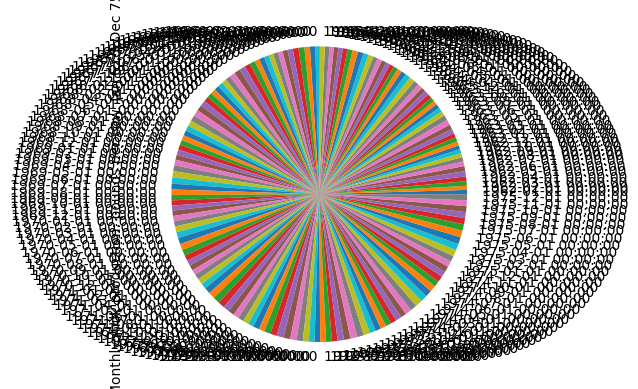

In [51]:
milk.plot(kind="pie")

<AxesSubplot: xlabel='Month'>

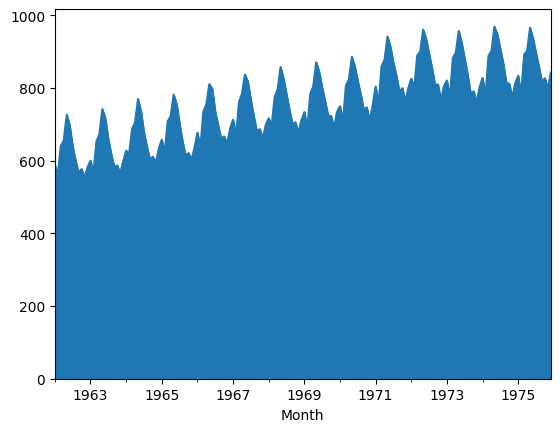

In [55]:
milk.plot(kind="area")

# Partie 2 :SPMF #

Nous avons vu en TD la librairie spmf développée en Java par Philippe Fournier-Vigier. 
Il est possible de l'appeler en python par la librairie Spmf. Voici un exemple.
Il faut pour cela télécharger le fichier spmf.jar de spmf, 

https://www.philippe-fournier-viger.com/spmf/index.php?link=download.php

et installer le wrapper avec pip: pip install spmf. 


In [37]:
from spmf import Spmf
spmf = Spmf("PrefixSpan", input_filename="DATA/contextPrefixSpan.txt",
            output_filename="output.txt", arguments=[0.5])
# Si nécessaire vous pouvez utiliser la variable spmf_bin_location_dir="chemin répertoire smpf"
#  arguments: les arguments passés à SPMF et dépendant des algorithmes choisis. 
spmf.run()
print(spmf.to_pandas_dataframe())
spmf.to_csv("output.csv")


ModuleNotFoundError: No module named 'spmf'

## Exercice 2.
On considère la séquence <(A, 2), (B, 3), (A, 7), (C, 8), (B, 9),(D, 11),(C,12), (A,13), (B,14), (C,15)> et on s'intéresse à l'algorithme EMMA.

- Quelles sont les sorties de cet algorithme ?
- Quelle est la notion de support utilisée ?
- Executez l'algorithme sur l'exemple ci-dessus. Quels sont les épisodes obtenus?

# Complément : types de données temporelles en Python #

Diverses classes pour les données temporelles dans la librairie datetime (Voir https://docs.python.org/3.10/library/datetime.html)

- datetime.date avec pour attributs : year, month, and day.

- datetime.time avec pour attributs : hour, minute, second, microsecond, and tzinfo.

- datetime.datetime : combination of a date and a time avec pour attributs : year, month, day, hour, minute, second, microsecond, and tzinfo.

- datetime.timedelta : une durée expyimant la différence entre 2 instances de type *date*, *time* ou *datetime*. 

Un package : pytz pour travaille sur les zones horaires (https://pypi.org/project/pytz/)

## Traitement natif des dates en Python : datetime et dateutil

*datetime* (https://docs.python.org/2/library/datetime.html#date-objects) et *dateutil* sont deux modules Python permettant de travailler sur les dates.

Les méthodes suivantes permettent de travailler des objets de type *datetime* contenant un objet de type *date* et un objet de type *time*. (da.date et da.time permettent d'accéder au jour et à l'heure)

+ **datetime.strptime()**: création d'un objet de classe *datetime* à partir d'une représentation sous forme de chaînes de caractères d'une date et heure et d'un format  

+ **strftime(format)** : méthode applicable sur *date*, *datetime*, *time*, création d'une chaîne de caractères représentant le temps suivant le format donné   

+ des exemples de format 
    + %a : jour de la semaine abrégé	Sun, Mon, …, Sat (en_US); So, Mo, …, Sa (de_DE)
	+ %A : jour de la semaine complet	Sunday, ... (en_US); Sonntag, ...  (de_DE)
    + %d : jour du mois en nombre 	01, 02, …, 31 	 
    + %b : mois abrégé 	Jan, Feb, …, Dec (en_US); Jan, Feb, …, Dez (de_DE)
	+ %B : mois complet  	
    + %m : mois en nombre 01, 02, …, 12 	 
    + %y : année représentée par 00, 01, …, 99 	 
    + %Y : année représentée par 1970, 1988, 2001, 2013
    
**Pour avoir des dates en français vérifier que vous avez l'environnement local adapté dans votre répertoire avec la commande :** $locale -a
        
    - fr_FR
    - fr_FR.ISO8859-1
    - fr_FR.ISO8859-15
    - fr_FR.UTF-8

In [ ]:
from datetime import datetime
datetime?

In [ ]:
da = datetime(year=2023, month=2, day=7) # création d'un objet de type datetime
print("date:",da) 
da.strftime("%A %d %B %Y") # chaîne de caractères représentant le temps suivant le format donné

date: 2023-02-07 00:00:00


'Mardi 07 février 2023'

In [ ]:
# Voir https://dateutil.readthedocs.io/en/stable/
# https://dateutil.readthedocs.io/en/stable/parser.html
# generic date/time string parser, able to parse most known formats to represent a date and/or time
# Retourne un objet de type datetime.datetime

d = parser.parse("7 février 2023", dayfirst=True, fuzzy=True)
print("date:", d)
parser.parse?

date: 2023-07-08 00:00:00


In [ ]:
import locale
locale.setlocale(locale.LC_ALL, 'fr_FR.UTF-8')
date_txt = "Dimanche 07 Février 2023"
DATE_FORMAT = "%A %d %B %Y"
datetime.strptime(date_txt, DATE_FORMAT)

datetime.datetime(2023, 2, 7, 0, 0)

In [ ]:
# inspiré de https://docs.python.org/fr/3.6/library/datetime.html
import time
from datetime import date
today = date.today() # équivalent à date.fromtimestamp(time.time())
print("Aujourd'hui :", today)
my_birthday = date(today.year, 6, 24) 
if my_birthday < today:
   my_birthday = my_birthday.replace(year=today.year + 1)
print("Mon prochain anniversaire:", my_birthday)
time_to_birthday = abs(my_birthday - today) # Objet de type  datetime.timedelta
print("Combien de jours à attendre:", time_to_birthday.days)

Aujourd'hui : 2023-02-08
Mon prochain anniversaire: 2023-06-24
Combien de jours à attendre: 136


## Numpy : données temporelles ##
Type de données : *datetime64* pour encoder les données temps comme des entiers 64 bits.  
Possibilité de faire des opérations vectorisées dessus.   
Un object *datetime64* ou *timedelta64* est fondé sur une unité de mesure fondamentale et est limité à une précision de $2^{64}$ bits de cette unité de mesure.   
L'unité de mesure fondamentale est déduite des entrées : 

    np.datetime64('2015-07-04') -> jour  
    np.datetime64('2015-07-04 12:00')-> minute   
    np.datetime64('2015-07-04 12:00', ns) -> nanoseconde 
    
Time zone: heure locale de l'ordinateur exécutant le code  


In [ ]:
import numpy as np
start =np.datetime64('2019-03-24')
print(start)

2019-03-24


Possibilité de créer des tableaux d'index

In [ ]:
start+np.arange(12) # Comme start a une précision en jour, créera un tableau de 12 dates avec un jour de décalage

array(['2019-03-24', '2019-03-25', '2019-03-26', '2019-03-27',
       '2019-03-28', '2019-03-29', '2019-03-30', '2019-03-31',
       '2019-04-01', '2019-04-02', '2019-04-03', '2019-04-04'],
      dtype='datetime64[D]')

## Exercice ##
1. Faire un index en année de 2000 à 2019 (compris)
2. Faire un index en heures du 1er janvier 2020 (0:00) au 3 janvier 2020 (23h)

## Pandas : données temporelles  

https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html

Fondés sur les types de données de Numpy datetime64 and timedelta64 dtypes. Attention des classes données dans la documentation sont "deprecated".


        
 **pd.to_datetime** :
 
     - peut prendre en entrées une grande variété de format     
     - crée un objet de type *Timestamp* si on lui passe une seule date, un objet de type *Datetimeindex* sinon
     
 **pd.to_timedelta** : 
 
     - fondé sur numpy.timedelta64
     - crée un objet de type *timedelta64* ou *numpy.array of timedelta64*

In [ ]:
import pandas as pd
date=pd.to_datetime("24th of March, 2020") # objet de type Timestamp car une seule entrée
print("type de date :",type(date))
print("date :", date)
date.strftime('%A')

type de date : <class 'pandas._libs.tslibs.timestamps.Timestamp'>
date : 2020-03-24 00:00:00


'Mardi'

In [ ]:
import numpy as np
pd.to_timedelta(np.arange(12),'D')

TimedeltaIndex([ '0 days',  '1 days',  '2 days',  '3 days',  '4 days',
                 '5 days',  '6 days',  '7 days',  '8 days',  '9 days',
                '10 days', '11 days'],
               dtype='timedelta64[ns]', freq=None)

In [ ]:
date+pd.to_timedelta(np.arange(12),'D')

DatetimeIndex(['2020-03-24', '2020-03-25', '2020-03-26', '2020-03-27',
               '2020-03-28', '2020-03-29', '2020-03-30', '2020-03-31',
               '2020-04-01', '2020-04-02', '2020-04-03', '2020-04-04'],
              dtype='datetime64[ns]', freq=None)

In [ ]:
dates = pd.to_datetime(["18th of March, 2019",datetime(2019,3,19), '20-03-2019'])
dates
#dates-dates[0]

DatetimeIndex(['2019-03-18', '2019-03-19', '2019-03-20'], dtype='datetime64[ns]', freq=None)

In [ ]:
dates-dates[0]

TimedeltaIndex(['0 days', '1 days', '2 days'], dtype='timedelta64[ns]', freq=None)

In [ ]:
dates.to_period('D') # ajout d'une fréquence

PeriodIndex(['2019-03-18', '2019-03-19', '2019-03-20'], dtype='period[D]')

### Index ###
Construction d'un objet de type Series indexé par le temps

In [ ]:
index = pd.DatetimeIndex(['2019-03-17', '2019-03-18','2019-03-19'],'D')
data=pd.Series([9,5,6], index=index)
data['2019-03-17':'2019-03-18']

2019-03-17    9
2019-03-18    5
Freq: D, dtype: int64

In [ ]:
data['2019']

2019-03-17    9
2019-03-18    5
2019-03-19    6
Freq: D, dtype: int64

## Exercice ##

On suppose que le prix mensuel moyen d'un litre de lait dans un supermarché a varié comme suit du 1er janvier au 1er décembre 2019

[0.92, 0.94, 0.93, 0.94, 0.95, 0.96, 0.92, 0.92, 0.93, 0.94, 0.95, 0.95]

Représentez ces données sous forme d'une série temporelle. 